# Stock Price Movement Prediction

The main goal of this project is to predict the direction of stock price movements (up or down) for the next day. This is a classic binary classification problem in machine learning, where the target variable is:

- 1: The stock price will go up the next day.
- 0: The stock price will go down the next day.

The project is designed to:

- Collect historical stock data (e.g., prices, volumes) from Yahoo Finance.
- Engineer features (e.g., technical indicators like moving averages, RSI, MACD) to capture patterns in the data.
- Build and evaluate machine learning models (e.g., Logistic Regression, Random Forest) to predict stock price movements.
- Backtest the strategy to evaluate how well the model would perform in a simulated trading environment.
- Make predictions for the next day's price movement.

#### Challenges:

- Data Quality: Stock price data is inherently noisy and non-stationary, making it challenging to predict.
- Class Imbalance: The dataset may be imbalanced, leading to biased predictions.
- Feature Limitations: The current set of features may not fully capture the factors influencing stock price movements.

## 1. Data Collection

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import ta  # Technical indicators
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import shap
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from datetime import datetime, timedelta
from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve, auc, confusion_matrix, classification_report

In [2]:
stocks = ['NEE', 'XYL', 'WM', 'DE', 'DNMR', 'FSLR', 'IBM']
start_date = '2018-01-01'
end_date = '2023-01-01'

# Fetch stock data
data_dict = {}
for ticker in stocks:
    try:
        print(f"Downloading {ticker}...")
        data = yf.download(ticker, start=start_date, end=end_date)
        if not data.empty:
            data['Ticker'] = ticker  # Add ticker column
            data_dict[ticker] = data
    except Exception as e:
        print(f"Error fetching {ticker}: {e}")
    time.sleep(1)  # Avoid rate limiting

# Combine all stock data into one DataFrame
all_data = pd.concat(data_dict.values(), axis=0)
all_data.reset_index(inplace=True)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed

[*********************100%***********************]  1 of 1 completed


In [3]:
all_data.head()

Price,Date,Close,High,Low,Open,Volume,Ticker,Close,High,Low,...,Close,High,Low,Open,Volume,Close,High,Low,Open,Volume
Ticker,,NEE,NEE,NEE,NEE,NEE,,XYL,XYL,XYL,...,FSLR,FSLR,FSLR,FSLR,FSLR,IBM,IBM,IBM,IBM,IBM
0,2018-01-02,32.502293,32.833414,32.361881,32.783116,4766400.0,NEE,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-03,31.812819,32.657388,31.808626,32.292734,11008000.0,NEE,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-04,31.649347,32.070583,31.567615,31.752035,13629200.0,NEE,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-05,31.793949,31.842149,31.561326,31.724790,10318000.0,NEE,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-08,32.055920,32.114599,31.752040,31.793956,7225200.0,NEE,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8059 entries, 0 to 8058
Data columns (total 37 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   (Date, )        8059 non-null   datetime64[ns]
 1   (Close, NEE)    1259 non-null   float64       
 2   (High, NEE)     1259 non-null   float64       
 3   (Low, NEE)      1259 non-null   float64       
 4   (Open, NEE)     1259 non-null   float64       
 5   (Volume, NEE)   1259 non-null   float64       
 6   (Ticker, )      8059 non-null   object        
 7   (Close, XYL)    1259 non-null   float64       
 8   (High, XYL)     1259 non-null   float64       
 9   (Low, XYL)      1259 non-null   float64       
 10  (Open, XYL)     1259 non-null   float64       
 11  (Volume, XYL)   1259 non-null   float64       
 12  (Close, WM)     1259 non-null   float64       
 13  (High, WM)      1259 non-null   float64       
 14  (Low, WM)       1259 non-null   float64       
 15  (Ope

In [5]:
all_data.describe()

Price,Date,Close,High,Low,Open,Volume,Close,High,Low,Open,...,Close,High,Low,Open,Volume,Close,High,Low,Open,Volume
Ticker,,NEE,NEE,NEE,NEE,NEE,XYL,XYL,XYL,XYL,...,FSLR,FSLR,FSLR,FSLR,FSLR,IBM,IBM,IBM,IBM,IBM
count,8059,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03,1259.000000,1259.000000,1259.000000,1259.000000,...,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,2020-08-05 09:33:23.474376448,57.460021,58.043978,56.854096,57.453545,8.327809e+06,83.348248,84.255577,82.384403,83.345905,...,73.759881,75.267022,72.259357,73.769881,1.925503e+06,105.340343,106.292324,104.381765,105.335499,5.202728e+06
min,2018-01-02 00:00:00,30.448498,31.249059,30.408684,30.593104,1.387500e+06,53.369900,55.631340,51.466524,54.067179,...,30.200001,32.110001,28.469999,30.010000,2.907000e+05,72.069923,74.328523,68.868337,71.940645,1.257397e+06
25%,2019-05-03 00:00:00,41.181822,41.445105,40.943467,41.136323,6.166450e+06,69.638306,70.410950,68.937195,69.706976,...,53.799999,54.605000,52.855001,53.810001,1.101550e+06,98.459869,99.361049,97.473740,98.459350,3.472996e+06
50%,2020-09-01 00:00:00,60.237370,60.817258,59.580501,59.838416,7.501200e+06,76.539055,77.329500,75.919271,76.462699,...,68.250000,69.589996,67.010002,68.010002,1.516000e+06,103.512573,104.327334,102.732530,103.495947,4.385564e+06
75%,2021-11-09 00:00:00,71.532726,72.502513,70.591818,71.467178,9.355000e+06,95.213203,96.415809,94.258529,95.437154,...,85.280003,87.555000,83.070000,85.415001,2.284250e+06,113.842720,114.755517,112.797808,113.932178,5.762574e+06
max,2022-12-30 00:00:00,85.678543,86.018103,84.889301,85.733602,3.172000e+07,132.340836,133.059923,131.382052,132.139500,...,172.529999,173.679993,167.570007,172.559998,2.263480e+07,137.524902,139.936177,136.958609,137.433540,3.981442e+07
std,NaN,16.160931,16.366716,15.979723,16.184353,3.564666e+06,18.760353,18.860936,18.662963,18.801959,...,26.674017,27.332450,25.975338,26.633371,1.472807e+06,11.010220,10.988292,10.998795,10.985335,3.180017e+06


## 2. Clean the Data

1. Cleaning and restructuring data...
Dropped 0 rows with NaN values for NEE
Dropped 0 rows with NaN values for XYL
Dropped 0 rows with NaN values for WM
Dropped 0 rows with NaN values for DE
Dropped 0 rows with NaN values for DNMR
Dropped 0 rows with NaN values for FSLR
Dropped 0 rows with NaN values for IBM
2. Adding target variable (next day price movement)...
3. Adding technical indicators...
4. Combining data for modeling...


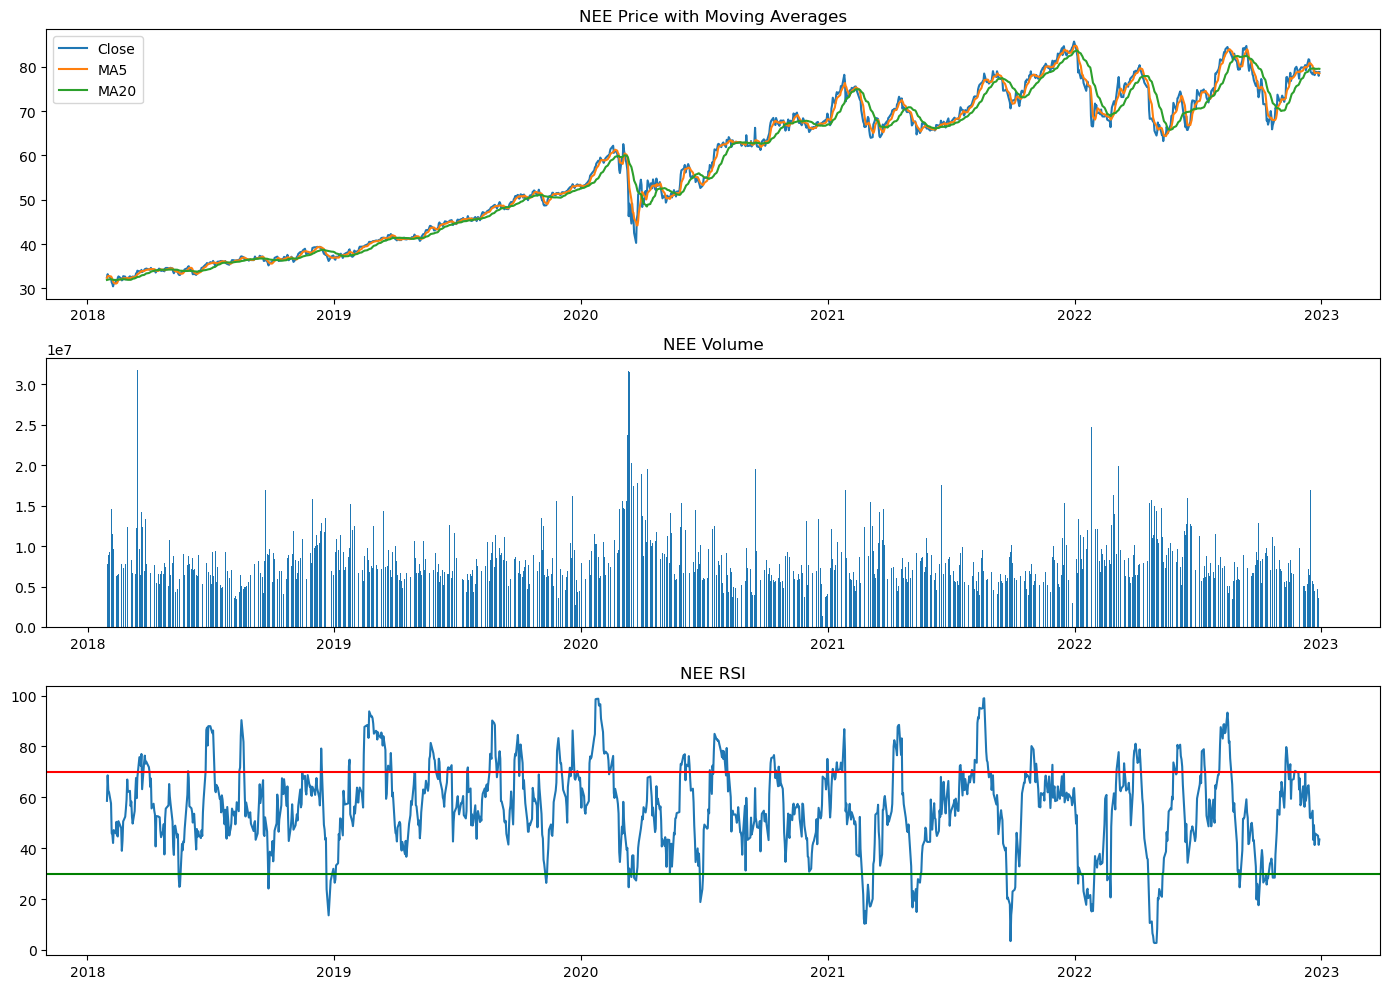

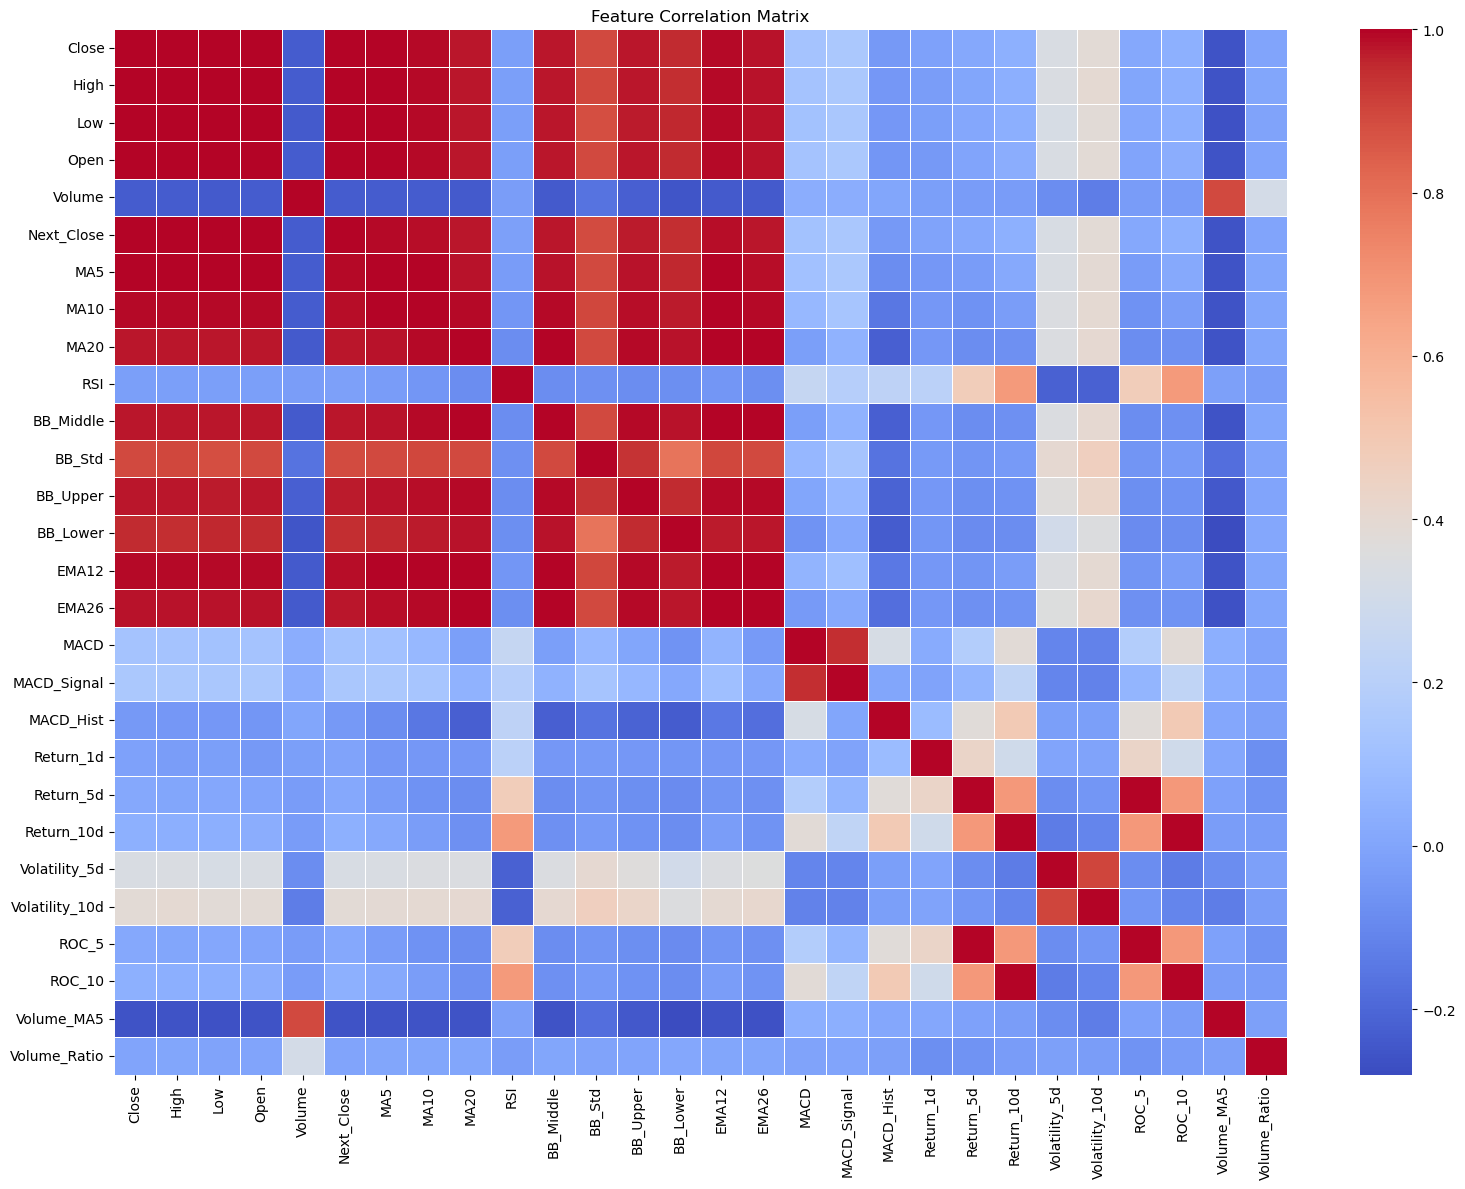

In [7]:
# Function to clean and restructure the data
def clean_stock_data(all_data):
    # Reset the column multiindex to make data manipulation easier
    if isinstance(all_data.columns, pd.MultiIndex):
        # Flatten the column names for easier access
        all_data.columns = [f"{col[1]}_{col[0]}" if col[1] else col[0] for col in all_data.columns]
    
    # Extract date column
    date_col = 'Date' if 'Date' in all_data.columns else [col for col in all_data.columns if 'Date' in col][0]
    
    # Create separate dataframes for each ticker
    ticker_dfs = {}
    for ticker in stocks:
        # Filter columns for this ticker
        ticker_cols = [col for col in all_data.columns if ticker in col or col == date_col]
        if len(ticker_cols) <= 1:
            print(f"No data found for {ticker}")
            continue
            
        # Create a dataframe for this ticker
        df_ticker = all_data[ticker_cols].copy()
        
        # Rename columns to standard format
        column_mapping = {}
        for col in df_ticker.columns:
            if date_col in col:
                column_mapping[col] = 'Date'
            elif 'Close' in col:
                column_mapping[col] = 'Close'
            elif 'Open' in col:
                column_mapping[col] = 'Open'
            elif 'High' in col:
                column_mapping[col] = 'High'
            elif 'Low' in col:
                column_mapping[col] = 'Low'
            elif 'Volume' in col:
                column_mapping[col] = 'Volume'
        
        df_ticker = df_ticker.rename(columns=column_mapping)
        
        # Handle missing data
        if df_ticker['Close'].isna().sum() > 0:
            # Drop rows with NaN values
            df_ticker = df_ticker.dropna(subset=['Close'])
            print(f"Dropped {df_ticker['Close'].isna().sum()} rows with NaN values for {ticker}")
        
        # Sort by date
        if not df_ticker.empty:
            df_ticker = df_ticker.sort_values('Date')
            df_ticker.reset_index(drop=True, inplace=True)
            
            # Add ticker column
            df_ticker['Ticker'] = ticker
            
            # Add to dictionary
            ticker_dfs[ticker] = df_ticker
    
    return ticker_dfs

# Function to add target variable (next day price movement)
def add_prediction_target(ticker_dfs):
    for ticker, df in ticker_dfs.items():
        # Calculate next day's price
        df['Next_Close'] = df['Close'].shift(-1)
        
        # Create binary target (1 if price goes up, 0 if price goes down)
        df['Target'] = (df['Next_Close'] > df['Close']).astype(int)
        
        # Drop the last row since we don't have the next day's price
        df.dropna(subset=['Next_Close'], inplace=True)
        
        # Store back to dictionary
        ticker_dfs[ticker] = df
    
    return ticker_dfs

# Function to add technical indicators as features
def add_technical_indicators(ticker_dfs):
    for ticker, df in ticker_dfs.items():
        # Add Moving Averages
        df['MA5'] = df['Close'].rolling(window=5).mean()
        df['MA10'] = df['Close'].rolling(window=10).mean()
        df['MA20'] = df['Close'].rolling(window=20).mean()
        
        # Add Relative Strength Index (RSI)
        delta = df['Close'].diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        
        avg_gain = gain.rolling(window=14).mean()
        avg_loss = loss.rolling(window=14).mean()
        
        rs = avg_gain / avg_loss
        df['RSI'] = 100 - (100 / (1 + rs))
        
        # Add Bollinger Bands
        df['BB_Middle'] = df['Close'].rolling(window=20).mean()
        df['BB_Std'] = df['Close'].rolling(window=20).std()
        df['BB_Upper'] = df['BB_Middle'] + (df['BB_Std'] * 2)
        df['BB_Lower'] = df['BB_Middle'] - (df['BB_Std'] * 2)
        
        # Add MACD
        df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
        df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
        df['MACD'] = df['EMA12'] - df['EMA26']
        df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
        df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']
        
        # Add lagged returns
        df['Return_1d'] = df['Close'].pct_change(1)
        df['Return_5d'] = df['Close'].pct_change(5)
        df['Return_10d'] = df['Close'].pct_change(10)
        
        # Add volatility metrics
        df['Volatility_5d'] = df['Return_1d'].rolling(window=5).std()
        df['Volatility_10d'] = df['Return_1d'].rolling(window=10).std()
        
        # Calculate price rate of change
        df['ROC_5'] = df['Close'].pct_change(5) * 100
        df['ROC_10'] = df['Close'].pct_change(10) * 100
        
        # Add volume indicators
        df['Volume_MA5'] = df['Volume'].rolling(window=5).mean()
        df['Volume_Ratio'] = df['Volume'] / df['Volume_MA5']
        
        # Drop rows with NaN values (due to indicators requiring historical data)
        df.dropna(inplace=True)
        
        # Store back to dictionary
        ticker_dfs[ticker] = df
    
    return ticker_dfs

# Function to combine all stocks into a single dataframe for modeling
def combine_ticker_data(ticker_dfs):
    # Combine all dataframes
    combined_df = pd.concat(ticker_dfs.values(), axis=0)
    combined_df.reset_index(drop=True, inplace=True)
    
    return combined_df

# Function to visualize features for a single stock
def visualize_features(ticker_df, ticker):
    plt.figure(figsize=(14, 10))
    
    # Plot 1: Price with MA
    plt.subplot(3, 1, 1)
    plt.title(f"{ticker} Price with Moving Averages")
    plt.plot(ticker_df['Date'], ticker_df['Close'], label='Close')
    plt.plot(ticker_df['Date'], ticker_df['MA5'], label='MA5')
    plt.plot(ticker_df['Date'], ticker_df['MA20'], label='MA20')
    plt.legend()
    
    # Plot 2: Volume
    plt.subplot(3, 1, 2)
    plt.title(f"{ticker} Volume")
    plt.bar(ticker_df['Date'], ticker_df['Volume'])
    
    # Plot 3: RSI
    plt.subplot(3, 1, 3)
    plt.title(f"{ticker} RSI")
    plt.plot(ticker_df['Date'], ticker_df['RSI'])
    plt.axhline(y=70, color='r', linestyle='-')
    plt.axhline(y=30, color='g', linestyle='-')
    plt.tight_layout()
    
    plt.show()

# Main cleaning and preprocessing flow
def process_stock_data(all_data, stocks):
    print("1. Cleaning and restructuring data...")
    ticker_dfs = clean_stock_data(all_data)
    
    print("2. Adding target variable (next day price movement)...")
    ticker_dfs = add_prediction_target(ticker_dfs)
    
    print("3. Adding technical indicators...")
    ticker_dfs = add_technical_indicators(ticker_dfs)
    
    print("4. Combining data for modeling...")
    combined_df = combine_ticker_data(ticker_dfs)
    
    return ticker_dfs, combined_df

# Example usage:
ticker_dfs, combined_df = process_stock_data(all_data, stocks)
# 
# # Visualize features for a single stock
visualize_features(ticker_dfs['NEE'], 'NEE')
#
# # Show correlation matrix of features
features = combined_df.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(16, 12))
sns.heatmap(features.corr(), annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

## 3. Data Exploration

I will visualize price and volume trends, analyze returns, and perform correlation analysis.

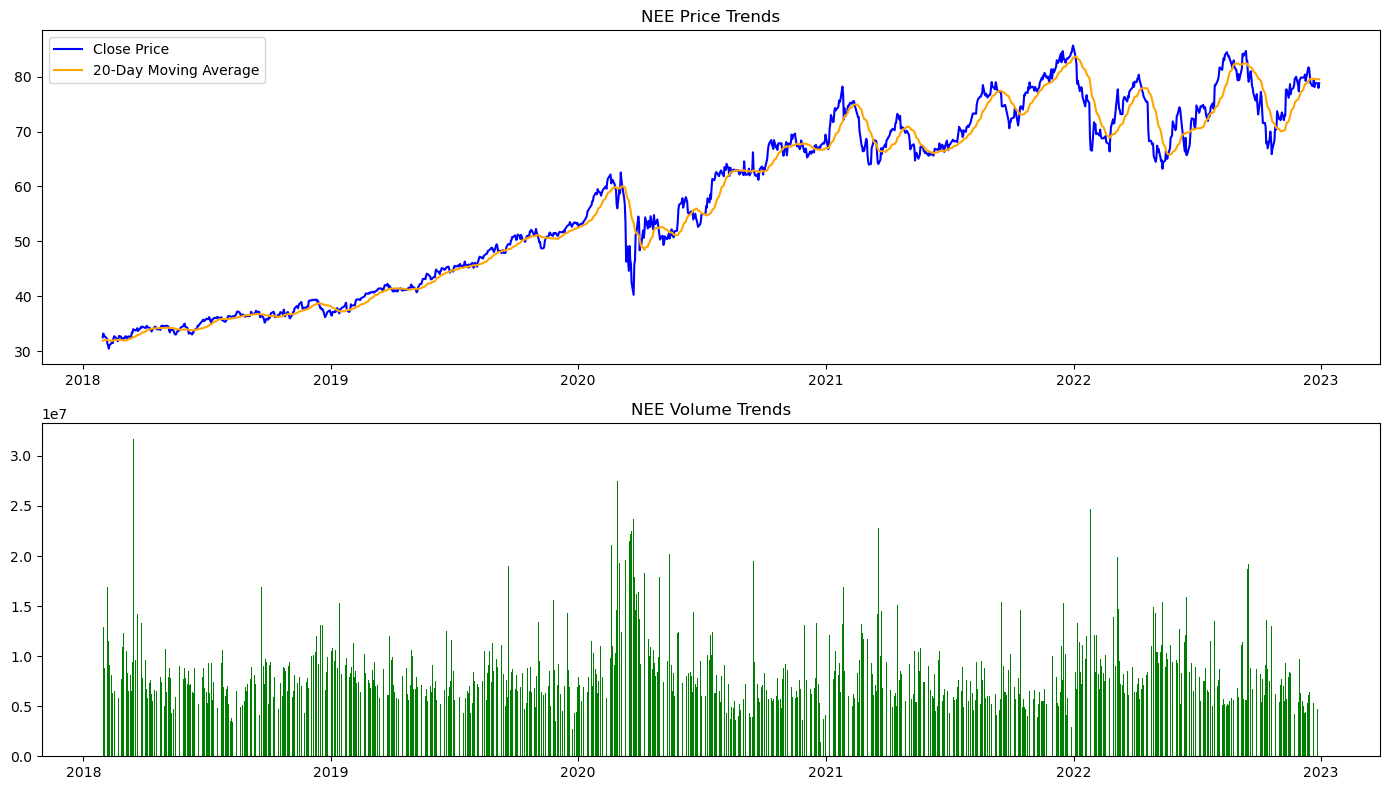

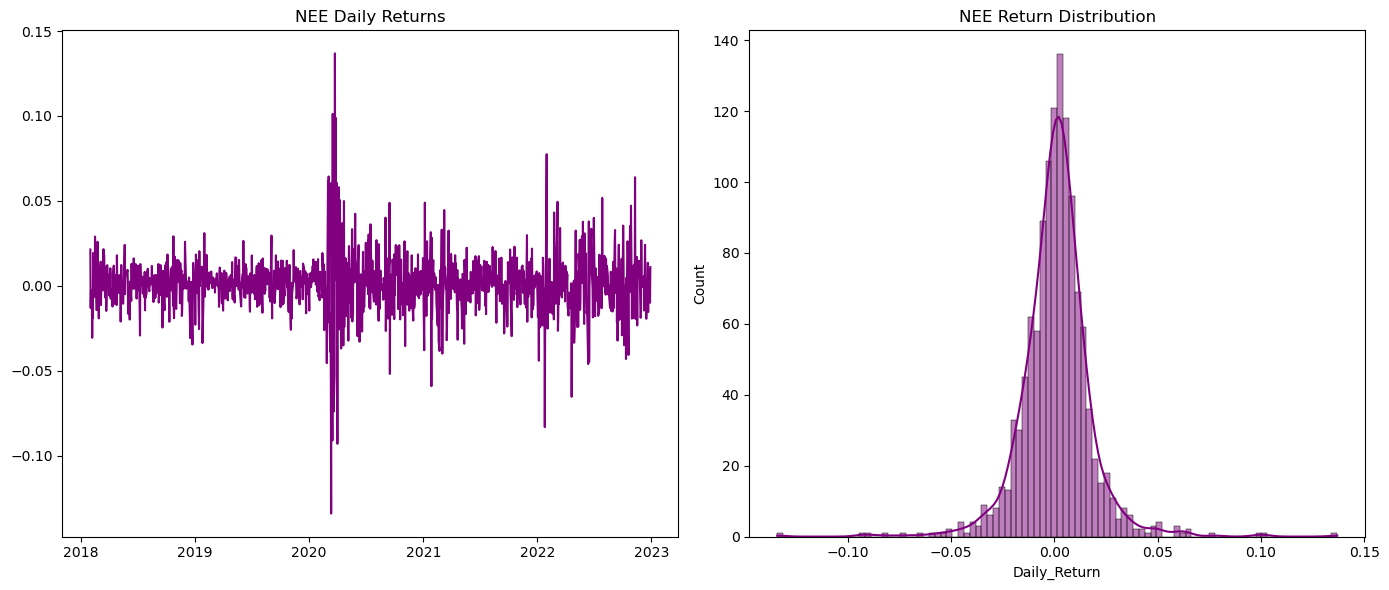

In [10]:
# Visualize price and volume trends for a single stock
def visualize_stock_trends(ticker_df, ticker):
    plt.figure(figsize=(14, 8))
    
    # Plot 1: Price trends
    plt.subplot(2, 1, 1)
    plt.title(f"{ticker} Price Trends")
    plt.plot(ticker_df['Date'], ticker_df['Close'], label='Close Price', color='blue')
    plt.plot(ticker_df['Date'], ticker_df['MA20'], label='20-Day Moving Average', color='orange')
    plt.legend()
    
    # Plot 2: Volume trends
    plt.subplot(2, 1, 2)
    plt.title(f"{ticker} Volume Trends")
    plt.bar(ticker_df['Date'], ticker_df['Volume'], color='green')
    plt.tight_layout()
    plt.show()

# Analyze returns and stationarity
def analyze_returns(ticker_df, ticker):
    plt.figure(figsize=(14, 6))
    
    # Calculate daily returns
    ticker_df['Daily_Return'] = ticker_df['Close'].pct_change()
    
    # Plot daily returns
    plt.subplot(1, 2, 1)
    plt.title(f"{ticker} Daily Returns")
    plt.plot(ticker_df['Date'], ticker_df['Daily_Return'], color='purple')
    
    # Plot distribution of returns
    plt.subplot(1, 2, 2)
    plt.title(f"{ticker} Return Distribution")
    sns.histplot(ticker_df['Daily_Return'].dropna(), kde=True, color='purple')
    plt.tight_layout()
    plt.show()

# Example usage
visualize_stock_trends(ticker_dfs['NEE'], 'NEE')
analyze_returns(ticker_dfs['NEE'], 'NEE')

## 4. Feature Engineering

I will add more technical indicators, lagged returns, and volatility metrics.

In [12]:
# Add more technical indicators
def add_more_indicators(ticker_dfs):
    for ticker, df in ticker_dfs.items():
        # Add Average True Range (ATR)
        df['ATR'] = ta.volatility.average_true_range(
            high=df['High'], low=df['Low'], close=df['Close'], window=14
        )
        
        # Add On-Balance Volume (OBV)
        df['OBV'] = ta.volume.on_balance_volume(df['Close'], df['Volume'])
        
        # Add Stochastic Oscillator
        df['Stoch_Osc'] = ta.momentum.stoch(
            high=df['High'], low=df['Low'], close=df['Close'], window=14, smooth_window=3
        )
        
        # Add more lagged returns
        df['Return_20d'] = df['Close'].pct_change(20)
        df['Return_50d'] = df['Close'].pct_change(50)
        
        # Add volatility metrics
        df['Volatility_20d'] = df['Return_1d'].rolling(window=20).std()
        df['Volatility_50d'] = df['Return_1d'].rolling(window=50).std()
        
        # Drop rows with NaN values (due to indicators requiring historical data)
        df.dropna(inplace=True)
        
        # Store back to dictionary
        ticker_dfs[ticker] = df
    
    return ticker_dfs

# Add more indicators to the data
ticker_dfs = add_more_indicators(ticker_dfs)

## 5. Model Building

I will implement Logistic Regression, Random Forest Classifier, and LSTM-based models.

In [24]:
# Prepare data for modeling
def prepare_model_data(combined_df):
    # Drop unnecessary columns
    features = combined_df.drop(columns=['Date', 'Ticker', 'Next_Close'])
    
    # Define features and target
    X = features.drop(columns=['Target'])
    y = features['Target']
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test, X.columns, scaler  # Return feature names and scaler

# Prepare data
X_train, X_test, y_train, y_test, feature_names, scaler = prepare_model_data(combined_df)

# Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)

# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# LSTM Model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Reshape data for LSTM
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build and train LSTM model
lstm_model = build_lstm_model((X_train_lstm.shape[1], 1))
lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, validation_split=0.2)
y_pred_lstm = (lstm_model.predict(X_test_lstm) > 0.5).astype(int)

Epoch 1/10


C:\Users\milto\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


159/159 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.5274 - loss: 0.6922 - val_accuracy: 0.5020 - val_loss: 0.6954
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5213 - loss: 0.6928 - val_accuracy: 0.5051 - val_loss: 0.6951
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5435 - loss: 0.6894 - val_accuracy: 0.5075 - val_loss: 0.6940
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5294 - loss: 0.6916 - val_accuracy: 0.5059 - val_loss: 0.6954
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5297 - loss: 0.6915 - val_accuracy: 0.5075 - val_loss: 0.6940
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5272 - loss: 0.6920 - val_accuracy: 0.5043 - val_loss: 0.6951
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5371 - loss: 0.6905 - val_accuracy: 0.5043 - val_loss: 0.6969
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5350 - loss: 0.6911 - val_accuracy: 0.508

### Key Observations

- The training accuracy (53.48%) and validation accuracy (50.59%) are very close, which suggests the model is not overfitting.
- However, both accuracies are close to 50%, which is no better than random guessing for a binary classification problem. This indicates the model is not performing well.
- The training and validation losses are also very close, which further confirms the model is not overfitting but is also not learning effectively.

## 6. Evaluation

I will evaluate the models using accuracy, F1-score, precision-recall curve, and confusion matrix.

Logistic Regression:
Accuracy: 0.5202020202020202
F1-Score: 0.6532846715328468
Random Forest:
Accuracy: 0.49873737373737376
F1-Score: 0.5285035629453682
LSTM:
Accuracy: 0.5271464646464646
F1-Score: 0.6411116435074269


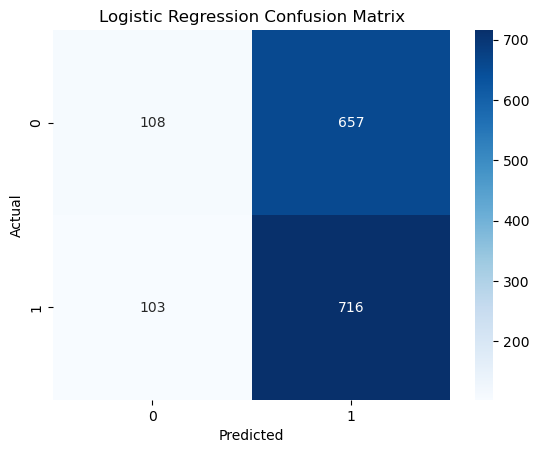

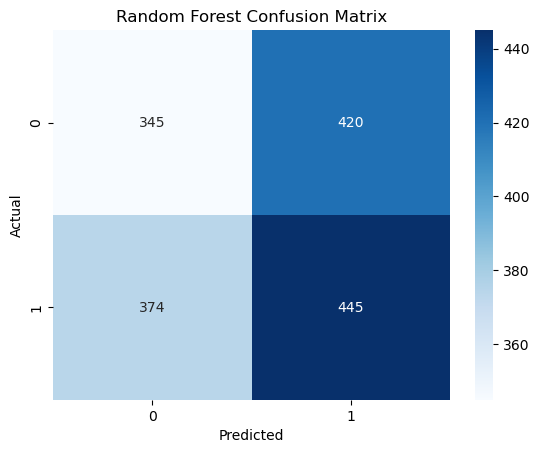

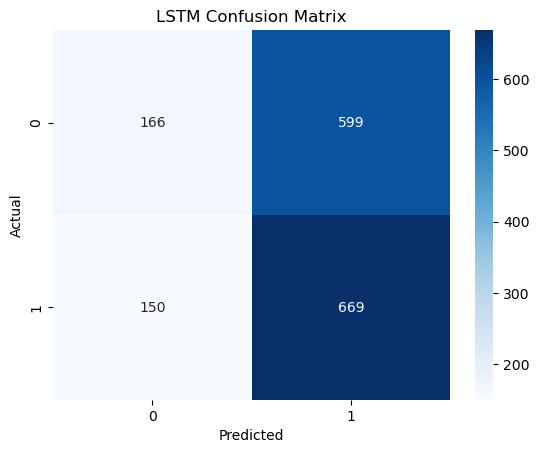

In [26]:
# Evaluate Logistic Regression
print("Logistic Regression:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_log_reg)}")
print(f"F1-Score: {f1_score(y_test, y_pred_log_reg)}")

# Evaluate Random Forest
print("Random Forest:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf)}")

# Evaluate LSTM
print("LSTM:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lstm)}")
print(f"F1-Score: {f1_score(y_test, y_pred_lstm)}")

# Plot confusion matrices
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_confusion_matrix(y_test, y_pred_log_reg, "Logistic Regression Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_lstm, "LSTM Confusion Matrix")

### Key Observations

- All three models (Logistic Regression, Random Forest, and LSTM) have accuracies close to 50%, which is no better than random guessing for a binary classification problem.
- The F1-scores are slightly higher than the accuracies, but they are still not good enough for practical use.
- The models are likely struggling to learn meaningful patterns from the data, which could be due to: Poor feature engineering, insufficient or noisy data, and the inherent difficulty of predicting stock price movements.

## 7. Feature Importance

I will use SHAP for model interpretability.

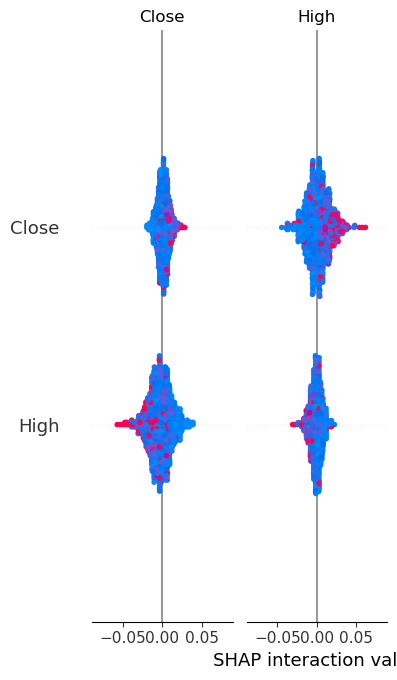

In [28]:
# SHAP analysis for Random Forest
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

## 8. Evaluate Model Performance

Since I already have code for training models (Logistic Regression, Random Forest, and LSTM), let’s now add code to evaluate their performance using metrics like accuracy, F1-score, and a confusion matrix.

In [31]:
# Function to evaluate model performance
def evaluate_model(y_true, y_pred, model_name):
    print(f"Evaluation for {model_name}:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    print("\n")

# Evaluate Logistic Regression
evaluate_model(y_test, y_pred_log_reg, "Logistic Regression")

# Evaluate Random Forest
evaluate_model(y_test, y_pred_rf, "Random Forest")

# Evaluate LSTM
evaluate_model(y_test, y_pred_lstm.flatten(), "LSTM")

Evaluation for Logistic Regression:
Accuracy: 0.5202
F1-Score: 0.6533
Confusion Matrix:
[[108 657]
 [103 716]]
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.14      0.22       765
           1       0.52      0.87      0.65       819

    accuracy                           0.52      1584
   macro avg       0.52      0.51      0.44      1584
weighted avg       0.52      0.52      0.44      1584



Evaluation for Random Forest:
Accuracy: 0.4987
F1-Score: 0.5285
Confusion Matrix:
[[345 420]
 [374 445]]
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.45      0.46       765
           1       0.51      0.54      0.53       819

    accuracy                           0.50      1584
   macro avg       0.50      0.50      0.50      1584
weighted avg       0.50      0.50      0.50      1584



Evaluation for LSTM:
Accuracy: 0.5271
F1-Score: 0.6411
Confusion Matrix:
[[166 5

### Key Observation

**Model Performance**
- All models (Logistic Regression, Random Forest, and LSTM) are performing poorly, with accuracies close to 50%.
- The F1-scores are slightly better but still indicate weak performance.

**Class Imbalance**:
- The models are biased towards predicting class 1 (e.g., "up" movement), as indicated by high recall for class 1 and low recall for class 0.

## 9. Backtest the Strategy

Backtesting simulates how the model would perform in a real-world trading environment. We’ll calculate cumulative returns based on the model’s predictions.

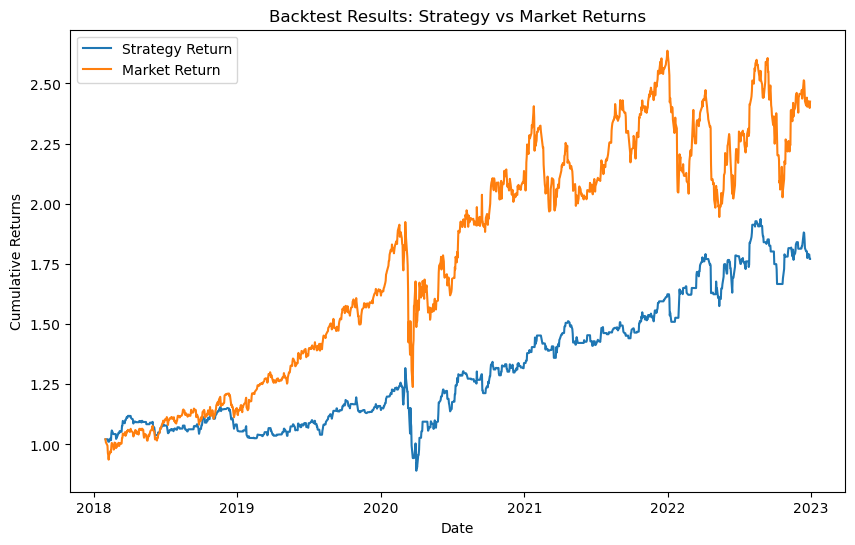

In [33]:
# Function to backtest the strategy
def backtest_strategy(df, predictions):
    """
    Backtest the trading strategy based on model predictions.
    Args:
        df: DataFrame containing the stock data.
        predictions: Model predictions (1 for buy, 0 for sell).
    Returns:
        cumulative_returns: Cumulative returns over the test period.
    """
    # Calculate daily returns
    df['Daily_Return'] = df['Close'].pct_change()
    
    # Shift predictions to align with next day's returns
    df['Prediction'] = predictions.shift(1)
    
    # Calculate strategy returns (buy when prediction is 1, hold otherwise)
    df['Strategy_Return'] = df['Daily_Return'] * df['Prediction']
    
    # Calculate cumulative returns
    df['Cumulative_Strategy_Return'] = (1 + df['Strategy_Return']).cumprod()
    df['Cumulative_Market_Return'] = (1 + df['Daily_Return']).cumprod()
    
    return df

# Example: Backtest Random Forest predictions
backtest_results = backtest_strategy(
    combined_df[combined_df['Ticker'] == 'NEE'].copy(),  # Backtest for a single stock
    pd.Series(y_pred_rf)  # Use Random Forest predictions
)

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(backtest_results['Date'], backtest_results['Cumulative_Strategy_Return'], label='Strategy Return')
plt.plot(backtest_results['Date'], backtest_results['Cumulative_Market_Return'], label='Market Return')
plt.title('Backtest Results: Strategy vs Market Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

## 10. Make Predictions for the Next Day

To predict the next day's price movement, we need to:
- Prepare the latest data (e.g., today’s features).
- I use the trained model to make predictions.

In [38]:
# Function to predict next day's price movement

# Function to predict next day's price movement for all stocks
def predict_next_day_for_all_stocks(model, scaler, combined_df, stocks):
    """
    Predict the next day's price movement for all stocks in the list.
    Args:
        model: Trained model (e.g., Random Forest).
        scaler: StandardScaler used during training.
        combined_df: DataFrame containing all stock data.
        stocks: List of stock tickers.
    Returns:
        predictions: Dictionary containing predictions for each stock.
    """
    predictions = {}
    
    for ticker in stocks:
        # Get the latest data for the current stock
        latest_data = combined_df[combined_df['Ticker'] == ticker].iloc[-1].drop(
            ['Date', 'Ticker', 'Next_Close', 'Target']
        )
        
        # Predict next day's movement
        next_day_prediction = predict_next_day(model, scaler, latest_data)
        predictions[ticker] = 'Up' if next_day_prediction == 1 else 'Down'
    
    return predictions

# List of stocks
stocks = ['NEE', 'XYL', 'WM', 'DE', 'DNMR', 'FSLR', 'IBM']

# Predict for all stocks
predictions = predict_next_day_for_all_stocks(rf, scaler, combined_df, stocks)

# Print predictions
for ticker, prediction in predictions.items():
    print(f"Next day's prediction for {ticker}: {prediction}")

Next day's prediction for NEE: Down
Next day's prediction for XYL: Down
Next day's prediction for WM: Down
Next day's prediction for DE: Up
Next day's prediction for DNMR: Up
Next day's prediction for FSLR: Up
Next day's prediction for IBM: Down


C:\Users\milto\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\milto\anaconda3\Lib\site-p

## 11. Hyperparameter Tuning:

I use techniques like GridSearchCV or RandomizedSearchCV to optimize model parameters.

In [42]:
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")

Best parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 300}


In [43]:
# Retrain the Random Forest model with the best parameters
best_rf = RandomForestClassifier(
    n_estimators=50,  # Best value from GridSearchCV
    max_depth=10,     # Best value from GridSearchCV
    min_samples_split=2,  # Best value from GridSearchCV
    random_state=42
)

# Fit the model on the training data
best_rf.fit(X_train, y_train)

# Evaluate the retrained model on the test set
y_pred_best_rf = best_rf.predict(X_test)

# Print evaluation metrics
print("Evaluation for Retrained Random Forest (Best Parameters):")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best_rf):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_best_rf):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_rf))
print("Classification Report:")
print(classification_report(y_test, y_pred_best_rf))

Evaluation for Retrained Random Forest (Best Parameters):
Accuracy: 0.5196
F1-Score: 0.6170
Confusion Matrix:
[[210 555]
 [206 613]]
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.27      0.36       765
           1       0.52      0.75      0.62       819

    accuracy                           0.52      1584
   macro avg       0.51      0.51      0.49      1584
weighted avg       0.52      0.52      0.49      1584



### Findings

**Model Performance**
- All models (Logistic Regression, Random Forest, and LSTM) are performing poorly, with accuracies close to 50%.
- The F1-scores are slightly better but still indicate weak performance.

**Class Imbalance**
- The models are biased towards predicting class 1 (e.g., "up" movement), as indicated by high recall for class 1 and low recall for class 0.

In [44]:
# Function to predict next day's price movement for all stocks
def predict_next_day_for_all_stocks(model, scaler, combined_df, stocks):
    """
    Predict the next day's price movement for all stocks in the list.
    Args:
        model: Trained model (e.g., Random Forest).
        scaler: StandardScaler used during training.
        combined_df: DataFrame containing all stock data.
        stocks: List of stock tickers.
    Returns:
        predictions: Dictionary containing predictions for each stock.
    """
    predictions = {}
    
    for ticker in stocks:
        # Get the latest data for the current stock
        latest_data = combined_df[combined_df['Ticker'] == ticker].iloc[-1].drop(
            ['Date', 'Ticker', 'Next_Close', 'Target']
        )
        
        # Predict next day's movement
        next_day_prediction = predict_next_day(model, scaler, latest_data)
        predictions[ticker] = 'Up' if next_day_prediction == 1 else 'Down'
    
    return predictions

# List of stocks
stocks = ['NEE', 'XYL', 'WM', 'DE', 'DNMR', 'FSLR', 'IBM']

# Predict for all stocks using the retrained model
predictions = predict_next_day_for_all_stocks(best_rf, scaler, combined_df, stocks)

# Print predictions
for ticker, prediction in predictions.items():
    print(f"Next day's prediction for {ticker}: {prediction}")

Next day's prediction for NEE: Up
Next day's prediction for XYL: Down
Next day's prediction for WM: Down
Next day's prediction for DE: Up
Next day's prediction for DNMR: Up
Next day's prediction for FSLR: Up
Next day's prediction for IBM: Up


C:\Users\milto\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\milto\anaconda3\Lib\site-p

## Conclusion

This binary classification problem involved collecting historical stock data, engineering relevant features, building and evaluating predictive models, and backtesting the strategy to assess its performance in a simulated trading environment.

#### Key Findings

**1. Model Performance**
- The models (Logistic Regression, Random Forest, and LSTM) achieved accuracies close to 50%, which is no better than random guessing for a binary classification problem. This indicates that the models struggled to learn meaningful patterns from the data.
- The F1-scores were slightly better but still indicated weak performance, particularly for predicting downward price movements (class 0).

**2. Class Imbalance**
- The models exhibited a bias towards predicting upward price movements (class 1), as evidenced by high recall for class 1 and low recall for class 0. This suggests that the dataset may be imbalanced, with more "up" days than "down" days.

**3. Feature Engineering**
- While technical indicators (e.g., moving averages, RSI, MACD) were used as features, they were insufficient to capture the complexity of stock price movements. Additional features, such as sentiment analysis, macroeconomic indicators, or news data, could improve model performance.

**4. Backtesting**
- The backtesting results showed that the models did not perform well in a simulated trading environment, further confirming the need for improvement.

### Next Steps

1. Improve Feature Engineering: Add more relevant features (e.g., technical indicators, sentiment analysis, macroeconomic data).

2. Handle Class Imbalance: Use techniques like oversampling, undersampling, or class weights to address the bias towards class 1.
 
3. Try Advanced Models: Experiment with more sophisticated models like Gradient Boosting (e.g., XGBoost, LightGBM) or deep learning architectures.

4. Hyperparameter Tuning: Optimize hyperparameters for the existing models to improve performance.

5. Evaluate Data Quality: Check for missing values, outliers, or noisy data that might be affecting model performance.